<a href="https://colab.research.google.com/github/ale-camer/Finance/blob/master/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is a code in which we try to forecast grouped data, such as a company's sales, that is expected to present seasonality.

The data used here is from the API of the website [stockanalysis.com](www.stockanalysis.com) but the functions can be used or tailor to any other time serie, such as GDP's.

It's also important to clarify that MAPE stands for Mean Absolute Percentage Error, which is the metric used in this code to measure error rate of the forecasts.

## Packages

In [1]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.dates as dts
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

## Functions


In [2]:
ticker, sales = 1, 1
def stockRevenues(ticker=ticker):

    """
    The purpose of this function is only to download the revenue serie of any stock with data in stockanalysis.com
    """

    headers= { # data needed to download data
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:87.0) Gecko/20100101 Firefox/87.0',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
        'Cache-Control': 'max-age=0'
    }
  
    response = requests.get(f"https://stockanalysis.com/stocks/{ticker}/financials/quarterly", headers=headers) # downloading data
    data = response.text

    # formatting data
    stockDates = data.split('datekey')[1] 
    stockDates = stockDates.split(']')[0].split(",")
    stockDates = pd.DataFrame(stockDates)[0].apply(lambda a: re.findall('[0-9]+',a))
    stockDates2 = []
    for iter1 in range(len(stockDates)):
        stockDates2.append(pd.to_datetime(stockDates[iter1][2] + '-' + stockDates[iter1][1] + '-' + stockDates[iter1][0]).strftime('%d-%m-%Y'))
    
    stockRevenues = data.split(',"revenue":')[1]
    stockRevenues = stockRevenues.split(']')[0].split(",")
    stockRevenues = pd.DataFrame(stockRevenues)[0].apply(lambda a: re.findall('[0-9]+',a))
    stockRevenues2 = []
    for elem in stockRevenues:
        stockRevenues2.append(int(elem[0])) 

    df = pd.DataFrame([stockDates2,stockRevenues2]).T.rename(columns={0:'date',1:'revenues'})
    df['date'] = pd.to_datetime(df['date'])
    df['revenues'] = pd.to_numeric(df['revenues'])
    df.set_index('date',inplace=True)
    df = df[::-1]
  
    return df

def forecasting(sales=sales,periodicity=4):

    """
    The purpose of this function is to predict a time serie base only on its seasonality. Therefore, the modulus between the length of the serie and its periodicity must be cero.

    The periodicity can be anyone. In this case it's harcoded a quarterly periodicity because we are dealing with quarterly data of listed companies revenues.

    Therefore, the following are examples of the different periodicities that can be used:

    - 2: biannual
    - 4: quarterly
    - 6: bimonthly
    - 12: monthly
    - 52: weekly
    - 365: daily    
    """

    if len(sales) % periodicity == 0:
      pass
    else:
      return print("The length of the serie does not much with it's periodicity.")
        
    # constants
    ones, pastPeriods, nextPeriod, seas_index = [1] * len(sales), np.arange(1,len(sales)+1), np.arange(len(sales)+1,len(sales)+1+periodicity), []

    sales_cma = sales.rolling(periodicity).mean().dropna().rolling(2).mean().dropna() # rolling mean
    
    if len(sales_cma) == periodicity: # irregular seasonal component
        irr_seas_comp = sales[int(periodicity/2):-int(periodicity/2)][-periodicity:].values / sales_cma.values
    else:
        irr_seas_comp = sales[int(periodicity/2):-int(periodicity/2)][-periodicity*int((len(sales)/periodicity)-1):].values / sales_cma.values
    
    if (len(irr_seas_comp) == periodicity) or (len(irr_seas_comp) == periodicity+1): # seasonal index
        seas_index = irr_seas_comp.copy()
    else:
        for i in range(periodicity): 
            seas_index.append((irr_seas_comp[i]+irr_seas_comp[i+int(len(irr_seas_comp)/2)])/2)
              
    seas_index = np.concatenate([seas_index[int(periodicity/2):], seas_index[:int(periodicity/2)]]) 
    adjustment = len(seas_index)/sum(seas_index)
    adj_seas_ind = np.concatenate(np.concatenate([[seas_index * adjustment] * int(len(sales)/len(seas_index))])) # adjusted seasonal index
    X, y = np.array([ones,pastPeriods]).T, sales/adj_seas_ind # data separation
    b = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # linear regression
    fut_unseas_sales = b[0] + b[1] * nextPeriod # unseasonal sales
    forecast = []
    for elem in range(len(fut_unseas_sales)): # forecast
      forecast.append(fut_unseas_sales[elem] * (seas_index[elem] * adjustment[0])[0])
      # forecast.append(fut_unseas_sales[elem] * (seas_index[elem] * adjustment))

    return forecast

## Data

              revenues
date                  
2012-09-30  1262000000
2012-12-31  1585000000
2013-03-31  1458000000
2013-06-30  1813000000
2013-09-30  2016000000 



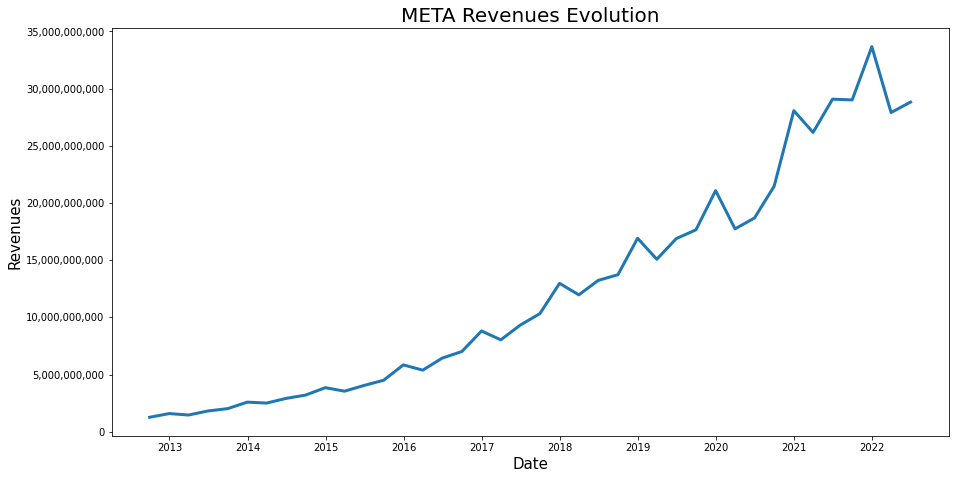

In [ ]:
ticker, periodicity = 'meta', 4 # choosing a stock and defining it's revenues periodicity
df = stockRevenues(ticker=ticker) # applying custom function
print(df.head(), '\n') # printing downloaded data 

plt.figure(figsize=(15,7.5)) # plotting data
plt.plot(df.index,df.revenues,linewidth=3)
plt.ylabel('Revenues',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.title(f'{ticker.upper()} Revenues Evolution',fontsize=20)
plt.ticklabel_format(style='plain', axis='y')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Here we can see that META revenues has a positive trend with a seasonallity in which revenues fall in the first quarter, increase a little bit in the second and third quarters and skyrocket in the fourth. 

## Forecast

In [ ]:
xHatNextPeriod = forecasting(sales=df,periodicity=periodicity) # forecast for the next period
xHatPresentPeriod = forecasting(sales=df.iloc[:-periodicity,:],periodicity=periodicity) # forecast for the present period
xHatNextPeriod, xHatPresentPeriod # printing forecasts

([27698097671.37587, 30864276643.27439, 28519736159.21878, 32895231811.46323],
 [23673819708.921494,
  27911875826.542164,
  23698992759.219975,
  26124678385.461758])

## Trend

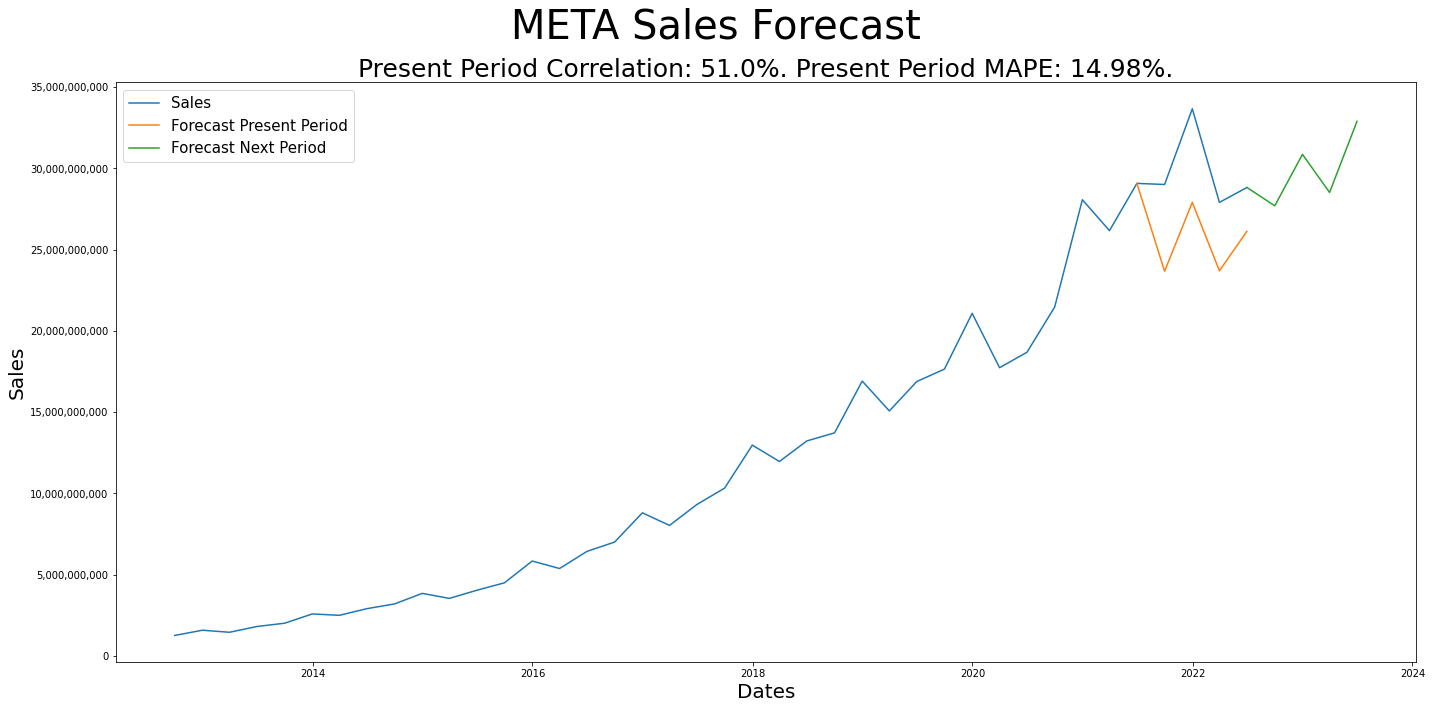

In [ ]:
forecastDates = pd.date_range(end=pd.to_datetime("today") + pd.DateOffset(months=12),periods=periodicity,freq='Q')
forecastDates = np.concatenate([pd.date_range(end=forecastDates[0] - pd.DateOffset(months=3),periods=1,freq='Q'),forecastDates])
realPresentSales, predictedPresentSales, predictedNextSales = np.concatenate(df.iloc[-periodicity-1:].values), np.concatenate([[df.iloc[-periodicity-1][0]],xHatPresentPeriod]), np.concatenate([[df.iloc[-1][0]],xHatNextPeriod])
presentCorr = round(np.corrcoef(x=realPresentSales,y=predictedPresentSales)[0][1]*100,2)
presentMAPE = round(mean_absolute_percentage_error(realPresentSales[1:],predictedPresentSales[1:])*100,2)

plt.figure(figsize=(20,10))
plt.plot(df.index,df.values,label='Sales')
plt.plot(df.index[-5:],predictedPresentSales,label='Forecast Present Period')
plt.plot(forecastDates,predictedNextSales,label='Forecast Next Period')
plt.ticklabel_format(style='plain', axis='y')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.legend(loc='best',fontsize=15)
plt.ylabel('Sales',fontsize=20)
plt.xlabel('Dates',fontsize=20)
plt.suptitle(f'{ticker.upper()} Sales Forecast',fontsize=40)
plt.title(f'Present Period Correlation: {presentCorr}%. Present Period MAPE: {presentMAPE}%.',fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.925])
plt.show()

Here we can see that the function is pretty good predicting the direction of the serie, because it has a clear seasonality, but is it pretty poor calculating it's values.

## Other Big Companies

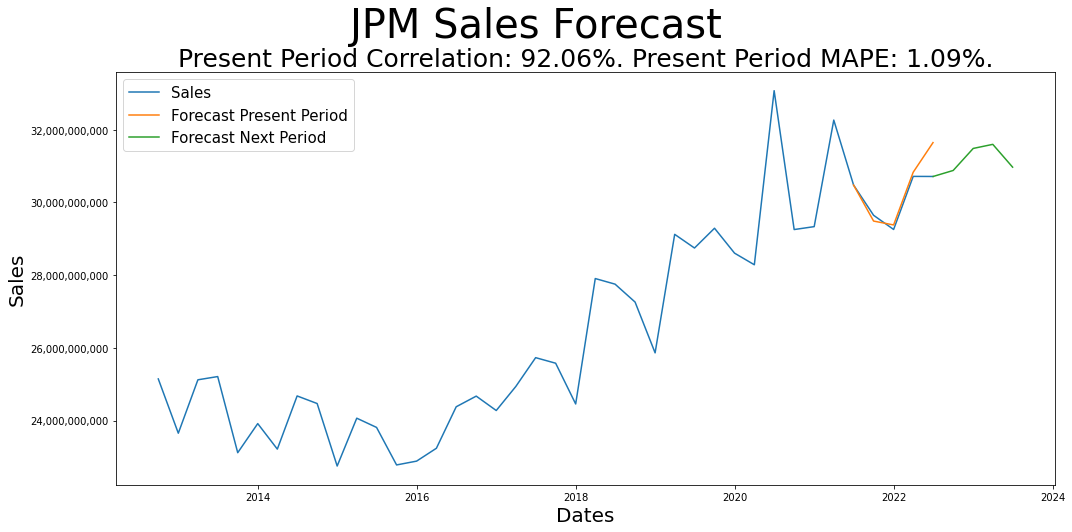

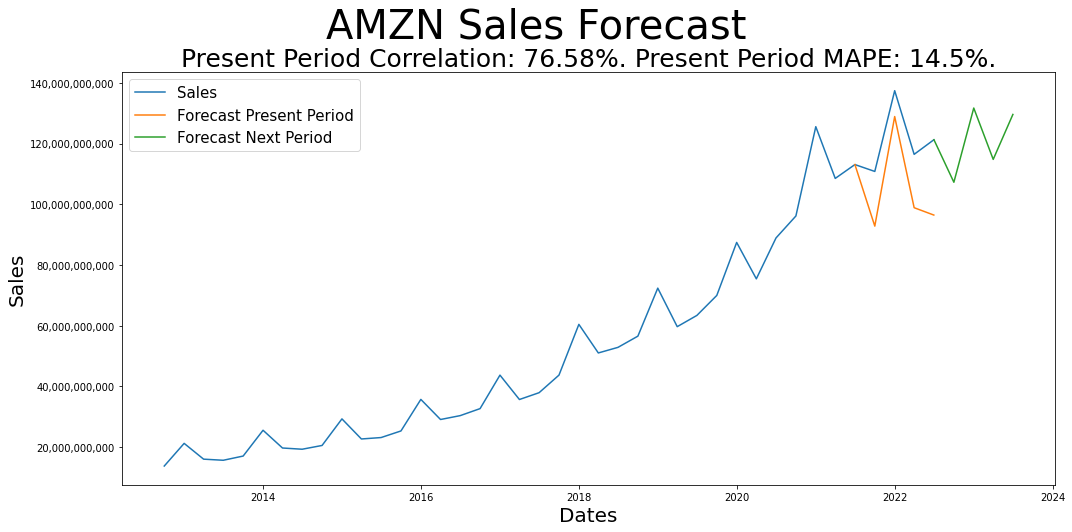

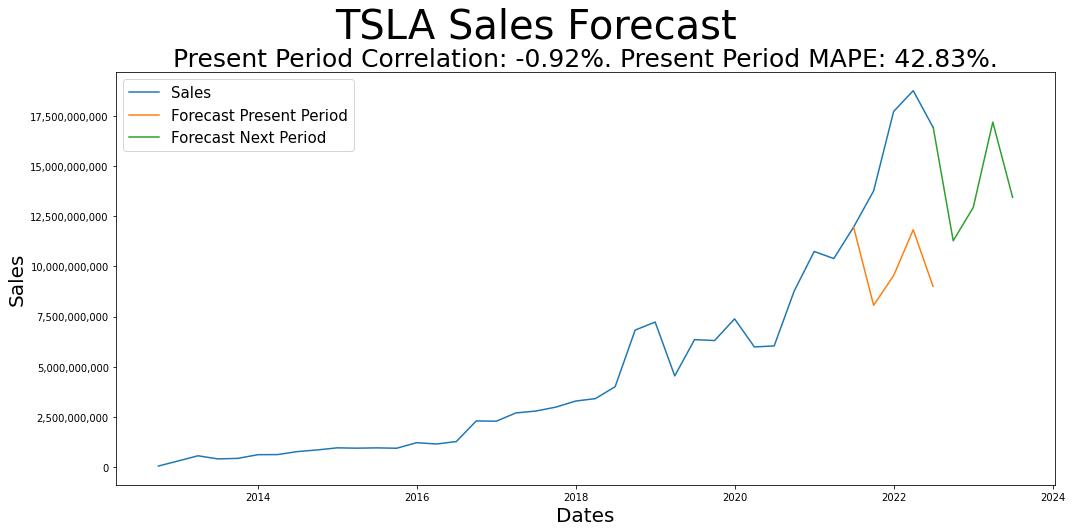

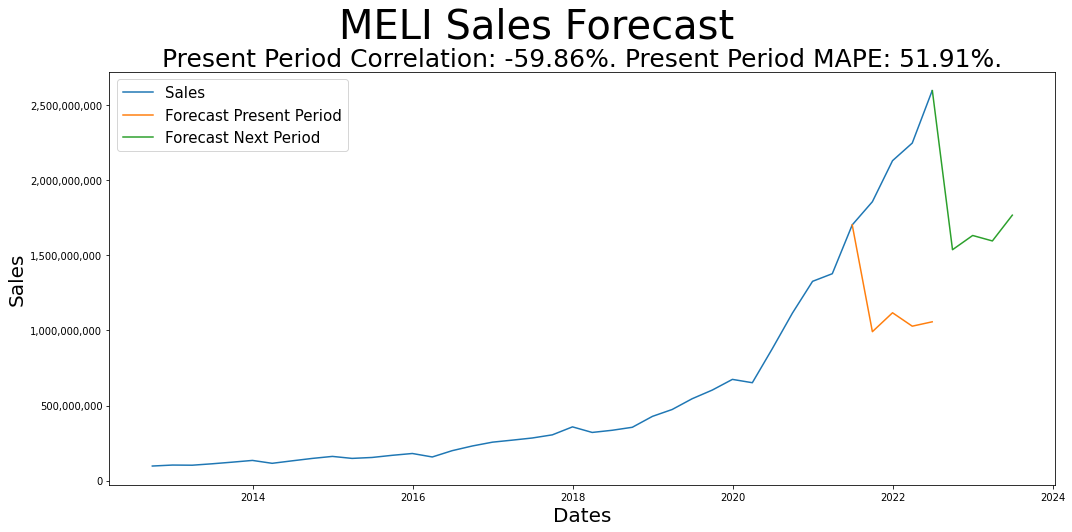

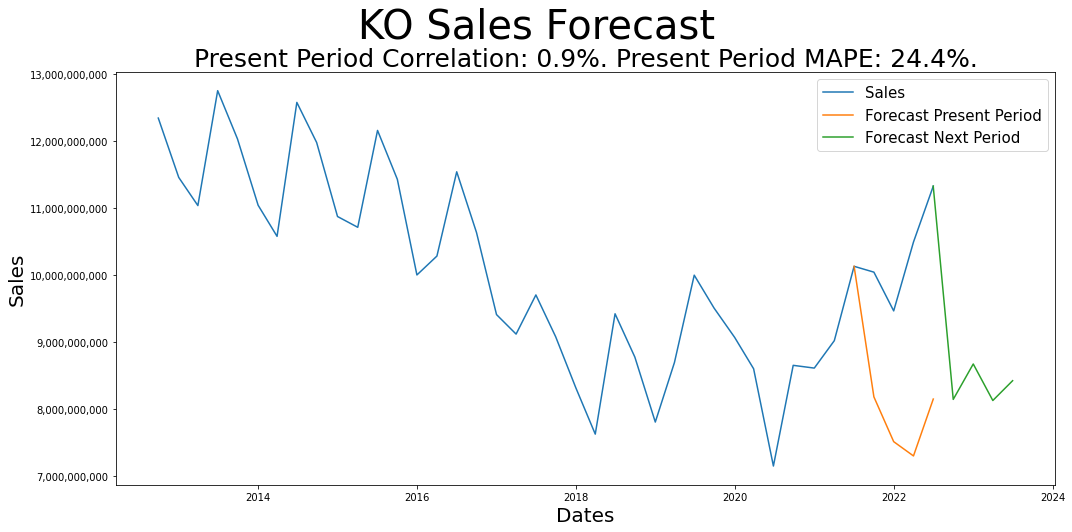

In [ ]:
tickers = ['jpm','amzn','tsla','meli','ko']
for tick in tickers:
            
  ticker, periodicity = tick, 4
  df = stockRevenues(ticker=ticker)
  xHatNextPeriod = forecasting(sales=df,periodicity=periodicity)
  xHatPresentPeriod = forecasting(sales=df.iloc[:-periodicity,:],periodicity=periodicity)
  
  forecastDates = pd.date_range(end=pd.to_datetime("today") + pd.DateOffset(months=12),periods=periodicity,freq='Q')
  forecastDates = np.concatenate([pd.date_range(end=forecastDates[0] - pd.DateOffset(months=3),periods=1,freq='Q'),forecastDates])
  realPresentSales, predictedPresentSales, predictedNextSales = np.concatenate(df.iloc[-periodicity-1:].values), np.concatenate([[df.iloc[-periodicity-1][0]],xHatPresentPeriod]), np.concatenate([[df.iloc[-1][0]],xHatNextPeriod])
  presentCorr = round(np.corrcoef(x=realPresentSales,y=predictedPresentSales)[0][1]*100,2)
  presentMAPE = round(mean_absolute_percentage_error(realPresentSales[1:],predictedPresentSales[1:])*100,2)
  
  plt.figure(figsize=(15,7.5))
  plt.plot(df.index,df.values,label='Sales')
  plt.plot(df.index[-5:],predictedPresentSales,label='Forecast Present Period')
  plt.plot(forecastDates,predictedNextSales,label='Forecast Next Period')
  plt.ticklabel_format(style='plain', axis='y')
  current_values = plt.gca().get_yticks()
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
  plt.legend(loc='best',fontsize=15)
  plt.ylabel('Sales',fontsize=20)
  plt.xlabel('Dates',fontsize=20)
  plt.title(f'Present Period Correlation: {presentCorr}%. Present Period MAPE: {presentMAPE}%.',fontsize=25)
  plt.suptitle(f'{ticker.upper()} Sales Forecast',fontsize=40)
  plt.tight_layout(rect=[0, 0, 1, 0.925])
  plt.show()

By watching other examples we can conclude that the model is good predicting JPM's revenues, a little bit less with AMZN and not at all with MELI, KO and TSLA. 

## Other S&P500 Companies

In [3]:
from tqdm import tqdm

stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

statistics = []
for bucket in range(11):

  # tickers = stocks[0]['Symbol']
  tickers = stocks[0][stocks[0]['GICS Sector'] == stocks[0]['GICS Sector'].unique()[bucket]]['Symbol']

  # statistics = []
  for tick in tickers.values:
      
    try:
        
      ticker, periodicity = tick, 4
      df = stockRevenues(ticker=ticker)
      xHatPresentPeriod = forecasting(sales=df.iloc[:-periodicity,:],periodicity=periodicity)
      
      realPresentSales, predictedPresentSales = np.concatenate(df.iloc[-periodicity-1:].values), np.concatenate([[df.iloc[-periodicity-1][0]],xHatPresentPeriod])
      presentCorr = round(np.corrcoef(x=realPresentSales,y=predictedPresentSales)[0][1]*100,2)
      presentMAPE = round(mean_absolute_percentage_error(realPresentSales[1:],predictedPresentSales[1:])*100,2)
      
      statistics.append((tick,presentCorr,presentMAPE))

    except:
      pass

statisticsDf = pd.DataFrame(statistics).rename(columns={0:'ticker',1:'correlation',2:'MAPE'}).set_index('ticker')
statisticsDf.sort_values('correlation',ascending=False)

The length of the serie does not much with it's periodicity.
The length of the serie does not much with it's periodicity.
The length of the serie does not much with it's periodicity.


,correlation,MAPE
ticker,,
MMM,81.19,4.51
DE,80.23,19.41
CTAS,71.25,3.21
ALK,58.49,14.31
CMI,24.22,4.96
AOS,-0.31,12.04
CPRT,-6.56,24.79
CAT,-12.75,18.02
BA,-12.89,19.92


These are other few examples in which we can appreciate the same that in the others examples that we saw. For same stocks the model work and for others don't. That's because these are all different events and we should treat them all differently. Nevertheless, this simple model it's pretty useful for any time serie with seasonality. Moreover, other elements beside the period could be include in the regression. 

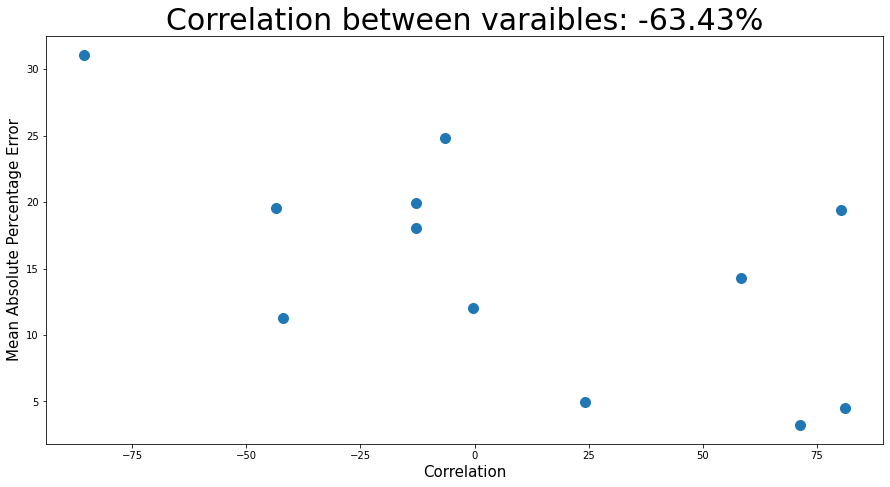

In [4]:
correlation = round(np.corrcoef(x=statisticsDf['correlation'],y=statisticsDf['MAPE'])[0][1]*100,2)

plt.figure(figsize=(15,7.5))
plt.scatter(statisticsDf['correlation'],statisticsDf['MAPE'],s=100)
plt.xlabel('Correlation',fontsize=15)
plt.ylabel('Mean Absolute Percentage Error',fontsize=15)
plt.title(f'Correlation between varaibles: {correlation}%',fontsize=30)
plt.show()

Here we can se that the metric used have a strong negative correlation. I would love to have all S&P500 listed companies data in order to have a better measure but the API doesn't allowed.